In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon, rankdata, t
import scikit_posthocs as sp
import itertools
import math
from matplotlib.lines import Line2D
from collections import defaultdict
from typing import List, Tuple
from collections import defaultdict
import textwrap
from scipy.stats import ttest_rel
import re
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [3]:
def calculate_smape(actual, predicted):
    
        # Convert actual and predicted to numpy
        # array data type if not already
        if not all([isinstance(actual, np.ndarray), 
                    isinstance(predicted, np.ndarray)]):
            actual, predicted = np.array(actual),
            np.array(predicted)
    
        return round(
            np.mean(
                np.abs(predicted - actual) / 
                ((np.abs(predicted) + np.abs(actual))/2)
            )*100, 2
        )

def calc_metrics(preds_df,model_type,rpi,filter,csv_name):


    if os.path.exists(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}'):
        # print(f'{csv_name} already exists. Loading metrics per inst.')
        return pd.read_csv(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}')

    print(f"Processing: {model_type}, {rpi}, {filter}, {csv_name}")
    metrics_per_inst, selected_resources_obs, selected_resources_prds = [], [], []
    selected_resources = ['cpu_user_time_diff', 'cpu_system_time_diff', 'cpu_idle_time_diff', 'memory']
    
    columns = preds_df.columns
    for col in columns:
        if 'obs' in col:
            selected_resources_obs.append(col)
        elif 'preds' in col:
            selected_resources_prds.append(col)
    
    def calculate_one_minus_r2(observations, predictions):

        true_values = [float(x) for x in observations]
        predicted_values = [float(x) for x in predictions]

        return 1 - r2_score(true_values, predicted_values)

    for obs, preds, res in zip(selected_resources_obs, selected_resources_prds, selected_resources):

        # Calculate metrics
        preds_df[res+'_MAE'] = preds_df.apply(lambda row: round(mean_absolute_error([row[obs]], [row[preds]]),3), axis=1)
        metrics_per_inst.append(res+'_MAE')
        preds_df[res+'_RMSE'] = preds_df.apply(lambda row: round(mean_squared_error([row[obs]], [row[preds]], squared=False),3), axis=1)
        metrics_per_inst.append(res+'_RMSE')
        # preds_df[res+'_1-R^2'] = preds_df.apply(lambda row: round(calculate_one_minus_r2([row[obs]], [row[preds]]),3), axis=1)
        # metrics_per_inst.append(res+'_1-R^2')
        preds_df[res+'_MAPE'] = preds_df.apply(lambda row: round(mean_absolute_percentage_error([row[obs]], [row[preds]])*100,2), axis=1)
        metrics_per_inst.append(res+'_MAPE')
        preds_df[res+'_SMAPE'] = preds_df.apply(lambda row: round(calculate_smape(np.array(row[obs]), np.array(row[preds])),2), axis=1)
        metrics_per_inst.append(res+'_SMAPE')
        
    result_df = preds_df[metrics_per_inst]

    os.makedirs(os.path.join('Results', model_type, rpi, filter,'metrics_per_inst'), exist_ok=True)

    print('Saving metrics to {}'.format(csv_name))
    # Save metrics to a CSV file
    result_df.to_csv(r'Results/{}/{}/{}/metrics_per_inst/{}'.format(model_type,rpi,filter,csv_name), index=False)

    return result_df


def get_step_size_name(step_size):
    step_size_dict = {'1Step': '1-step', '2Step': '2-step', '5Step': '5-step', '10Step': '10-step', '15Step': '15-step'}
    return step_size_dict.get(step_size)

def get_filter_name(filter_name):
    filter_dict = {'':'NoFilter', '_sg_5_2' : 'SavGol', '_sma_2': 'SMA', '_ema_1':'EMA' }
    return filter_dict.get(filter_name)


def shoelace_formula(x, y):
    """
    The Shoelace formula, also known as Gauss's area formula 
    or the surveyor's formula, is a method for calculating 
    the area of a simple polygon with known vertex coordinates. 
    The formula is named "Shoelace" because of the pattern the 
    multiplications create, which resembles lacing up a shoe.
    """
    return 0.5 * abs(sum(x[i] * y[i + 1] - x[i + 1] * y[i] for i in range(-1, len(x) - 1)))




def perform_friedman_nemenyi_wilcoxon_tests(data, prds_data):
    """
    Perform Friedman test, Wilcoxon test, and Nemenyi test to compute critical difference diagram.
    """
    # Perform Friedman test

    # Check if there are at least 3 sets of samples
    if data.shape[1] >= 3:
      friedman_stat, friedman_p = friedmanchisquare(*[data[col] for col in data.columns])
      print(f"Friedman Test Results for {data.columns.get_level_values('Model_Filter')}:")
      print(f"  Stat: {friedman_stat}")
      print(f"  P-value: {friedman_p}\n")
      wilcoxon_p = 1
    else:
      # Perform Wilcoxon test for each pair of columns
      print(f"Wilcoxon Test Results  for {data.columns.get_level_values('Model_Filter')}::")
      for i, col1 in enumerate(data.columns):
        for j, col2 in enumerate(data.columns):
          if i < j:
            wilcoxon_stat, wilcoxon_p = wilcoxon(data[col1], data[col2])
            print(f"  {col1} vs {col2}:")
            print(f"    Stat: {wilcoxon_stat}")
            print(f"    P-value: {wilcoxon_p}\n")
            friedman_p = 1

    # check if prds_data (dataframe) is not empty
    if not prds_data.empty and (friedman_p < 0.05 or wilcoxon_p < 0.05):
        # Perform Nemenyi test
        metrics = prds_data.columns.to_list()
        metrics.remove('Model_Filter')
        nemenyi_dfs = []
        for metric in metrics:

            
            # Extract the relevant column and group by the Model_Filter
            grouped_data = prds_data[[metric, 'Model_Filter']].groupby('Model_Filter')
            # Transform the grouped data into a format suitable for the Nemenyi test
            data_for_nemenyi = [group[metric].values for _, group in grouped_data]

            # Perform the Nemenyi test
            nemenyi_result = sp.posthoc_nemenyi(data_for_nemenyi)

            # print("Nemenyi Test Results:")
            # print(nemenyi_result)

            # Convert the Nemenyi result to a DataFrame with appropriate column and index names
            nemenyi_dfs.append(pd.DataFrame(nemenyi_result, columns=data.columns, index=data.columns))
        
        return pd.concat(nemenyi_dfs)
    else:
        return None

def calculate_critical_difference(nemenyi_df, alpha=0.05):
    """
    Calculate the critical difference.
    """
    k = nemenyi_df.shape[1]
    N = nemenyi_df.shape[0]

    q_alpha = t.ppf(1 - alpha / (2 * k * (k - 1)), N - 1)
    cd = q_alpha * np.sqrt(k * (k + 1) / (6 * N))
    print(f"Critical difference: {cd:.3f}")
    return cd


def plot_critical_difference(nemenyi_df, step_size, cd, filename=None):
    """
    Plot the critical difference diagram using matplotlib.
    """
    average_ranks = pd.Series(nemenyi_df.apply(lambda x: rankdata(x, method="average"), axis=1).mean())

    # Sort average_ranks and names
    average_ranks = average_ranks.sort_values()
    sorted_indices = average_ranks.index
    names = nemenyi_df.columns[sorted_indices]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.subplots_adjust(left=0.1, right=0.9)

    ax.set_xlim(-0.5, len(average_ranks) - 0.5)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_position(("axes", 0.6))
    ax.xaxis.set_ticks_position("top")
    ax.yaxis.set_visible(False)
    #increase ticks size
    ax.tick_params(axis='both', which='major', labelsize=22)

    for pos in ["bottom", "left", "right"]:
        ax.spines[pos].set_visible(False)

    # CD bar
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1 - cd], [0.9, 0.9], color="k")
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.plot([len(average_ranks) - 1 - cd, len(average_ranks) - 1 - cd], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.text(len(average_ranks) - 1 - cd / 4.0, 0.92, "CD", ha="center", va="bottom", fontsize=26)

    # Pairwise comparisons
    comparisons = []
    for i, col1 in enumerate(names):
        for j, col2 in enumerate(names):
            if i < j:
                p_value = nemenyi_df.loc[col1, col2]
                if p_value.any() < 0.05:
                    comparisons.append((i, j))

    # for i, j in comparisons:
    #     ax.plot([i, j], [0.9, 0.9], color="k", lw=1)
    #     ax.plot([i, i], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)
    #     ax.plot([j, j], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)

    # Annotations
    for (i, j), name in zip(comparisons, names):
        print(name)
        ax.plot([i, i], [0.62, 0.55], color="k", lw=3)
        wrapped_name = textwrap.fill(str(name[1].split("_")[0])+'_'+str(("_".join(name[1].split("_")[1:]))), width=30)  # Wrap the name if it's too long
        level = (i % 3) * 0.19  # Alternate between 0, 1, 2, and 3 for separate levels
    
        if i % 3 == 0:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="bottom", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.68], color="k", linestyle="--", lw=1)
        else:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="top", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.55], color="k", linestyle="--", lw=1)
        


      
    # ax.set_title(f"Critical Difference Diagram for {step_size}", fontsize=12)
    # plt.tight_layout()

    if filename:
        fig_directory = os.path.join('Figures', 'Experiments', f"{filename}_CD.png")
        plt.savefig(fig_directory, bbox_inches='tight')

    
    plt.show()
    plt.close()



def create_filter_star_chart(data, title, y_lim, filename=None):
    
    scale = 1

    num_vars = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles, data.columns, color='grey', size=14)
    ax.set_rlabel_position(30)
    plt.yticks(color="grey", size=12)
    plt.ylim(0, y_lim * scale)

    groups = defaultdict(list)
    for index, data_values in data.iterrows():
        model_name, model_filter = index
        filter_type = model_filter
        groups[model_name].append((filter_type, data_values))

    areas = {}
    areas_list = []

    # Define color palettes for each group
    group_colors = {
        'Encoder-Decoder': sns.color_palette("Blues_r", len(groups['Encoder-Decoder'])), # Spectral_r, “Greens_r”
        'kNN-TSPI': sns.color_palette("Reds_r", len(groups['kNN-TSPI'])), # “Reds_r”, "Purples_r"
        'HSMM': sns.color_palette("Greens_r", len(groups['HSMM'])) # “Greys_r”
    }
    # all colors: https://seaborn.pydata.org/tutorial/color_palettes.html

    # Define linestylte palettes for each model
    model_linestyles = {
        'Encoder-Decoder': ['-.', '-', '--', ':'],
        'kNN-TSPI': ['-.', '-', '--', ':'],
        'HSMM': ['-.', '-', '--', ':']
    }


    for model_name, group_data in groups.items():
        group_color = group_colors.get(model_name)

        for filter_idx, (filter_type, data_values) in enumerate(group_data):
            data_values = np.concatenate((data_values, [data_values[0]]))
            angles_cycle = angles + angles[:1]

            x = data_values * np.cos(angles_cycle)
            y = data_values * np.sin(angles_cycle)

            area = shoelace_formula(x, y)
            model_filt_combo = filter_type
            print(model_filt_combo, area)
            areas_list.append(area)
            areas[model_filt_combo] = area

            # Find the index of the current filter type in the group data
            filter_idx = [x[0] for x in group_data].index(filter_type)

            # Compute the normalized area value
            area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


            # Compute the color for the current polygon based on the group color and the normalized area value
            color = group_color[filter_idx] if group_color else sns.color_palette("dark", 1)[0]
            shade = color if area_value == 0 else sns.blend_palette([color, 'white'], as_cmap=True)(area_value)

            print('Metric values:', data_values)

            # Scale data_values
            data_values = data_values * scale

            ax.plot(angles_cycle, data_values, linewidth=2, linestyle= model_linestyles.get(model_name)[filter_idx] , label=f"{model_name}_{filter_type}", color=color)
            ax.fill(angles_cycle, data_values, alpha=0.1, color=color)

            

    normalized_areas = (areas_list - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))
    

    print(title)
    # plt.legend(loc='lower right', bbox_to_anchor=(1.9, 0.25), fontsize=12)
    plt.gca().set_facecolor('white')
    

    if filename:
        fig_directory = os.path.join('Figures','Experiments',f"{filename}_Star.png")
        plt.savefig(fig_directory, bbox_inches='tight')
    
    plt.show()
    plt.close()

    return areas



def preprocess_data(data, normalization_method="min_max"):
    
    def min_max_scaling(column):
        return (column - global_min) / (global_max - global_min)

    def z_score_standardization(column):
        return (column - column.mean()) / column.std()

    def log_transformation(column):
        return np.log(column + 1 - column.min())

    def percentile_based_scaling(column):
        return (column - column.median()) / (column.quantile(0.75) - column.quantile(0.25))

    def unit_vector_scaling(column):
        norm = np.sqrt(np.sum(column**2))
        return column / norm

    normalization_methods = {
        "min_max": min_max_scaling,
        "z_score": z_score_standardization,
        "log": log_transformation,
        "percentile": percentile_based_scaling,
        "unit_vector": unit_vector_scaling,
    }

    if normalization_method not in normalization_methods:
        raise ValueError(f"Invalid normalization method: {normalization_method}")

    # Exclude the 'Filter_Type' column during normalization
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_normalized = data.copy()

    # Calculate the global min and max for all model/filter combinations
    global_min = data[numeric_columns].min().min()
    global_max = data[numeric_columns].max().max()

    # Apply the selected normalization method
    normalization_func = normalization_methods[normalization_method]
    data_normalized[numeric_columns] = data[numeric_columns].apply(normalization_func)

    return data_normalized



def remove_outliers(data, csv_file, directory):
    # Identify and remove outliers using IQR method
    Q1 = data.quantile(0.05, numeric_only=True)
    Q3 = data.quantile(0.95, numeric_only=True)
    IQR = Q3 - Q1
    
    # Align the DataFrame and Series before making the comparison
    lower_bound, _ = data.align(Q1 - 1.5 * IQR, axis=1, copy=False)
    upper_bound, _ = data.align(Q3 + 1.5 * IQR, axis=1, copy=False)
    
    # Find outliers
    outliers_mask = (data.lt(lower_bound) | data.gt(upper_bound)).any(axis=1)
    
    # Track the number of outliers
    outlier_count = outliers_mask.sum()
    
    # Display information about outliers
    if outlier_count > 0:
        print(f"File: {csv_file} - Total outliers: {outlier_count} - Directory: {directory}")
        print("Outliers count per metric:")
        print((data[outliers_mask]).count())
        print("Sample outlier values:")
        print(data[outliers_mask].head(5))  # Adjust the number of samples as needed
    
    # Remove outliers
    data = data[~outliers_mask]

    return data

def get_metric_per_inst(step_size, models, devices, filters, root_directory):
    preds_data = []
    for model in models:
        predictions_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                # try:
                
                    device_directory_predictions = os.path.join(root_directory, model, device, filter_name, 'metrics_per_inst')
                    
                    # Get all the csv files in the directory
                    csv_files = [f for f in os.listdir(device_directory_predictions) if f.endswith(step_size + '.csv')]

                    for csv_file in csv_files:
                        
                        predictions_file_path = os.path.join(device_directory_predictions, csv_file)

                        predictions_data = pd.read_csv(predictions_file_path)
                        predictions_data = predictions_data.applymap(parse_float)

                        predictions_data = calc_metrics(predictions_data, model, device, filter_name, csv_file)
                        
                        predictions_data = remove_outliers(predictions_data, csv_file, device_directory_predictions)

                        cols = predictions_data.columns

                        predictions_data['Model_Filter'] = model+'_'+get_filter_name(filter_name)
                        
                        reshaped_df = pd.DataFrame()
                        # Iterate over each metric and model-filter combination
                        for metric, model_filter in product(cols, predictions_data['Model_Filter'].unique()):
                            # Create a new column in the reshaped DataFrame for each model-filter combination
                            col_name = f'{metric}_{model_filter}'
                            metric_df = predictions_data.loc[predictions_data['Model_Filter'] == model_filter, metric]
                            reshaped_df[col_name] = metric_df.values
                        
                        predictions_data_frames.append(predictions_data)

               
                # except:
                #     print(f"Missing: {model}, {device}, {filter_name}, {step_size}")
 
        # Organizing Predictions Data
        combined_predictions_data = pd.concat(predictions_data_frames)
        
        preds_data.append(combined_predictions_data)


    return pd.concat(preds_data)

def get_metrics(step_size, models, devices, filters, root_directory):
    model_data = []
    for model in models:
        metrics_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                try:
                
                    device_directory_metrics = os.path.join(root_directory, model, device, filter_name, 'metrics')

                    # Get all the csv files in the directory
                    csv_files = [f for f in os.listdir(device_directory_metrics) if f.endswith(step_size + '.csv')]

                    for csv_file in csv_files:
                        
                        metrics_file_path = os.path.join(device_directory_metrics, csv_file)
                        metrics_data = pd.read_csv(metrics_file_path)

                        # metrics_data = remove_outliers(metrics_data, csv_file, device_directory_metrics)

                        metrics_data['Filter_Type'] = get_filter_name(filter_name)  # Add a new column with the filter_name
                        metrics_data_frames.append(metrics_data)
                        
                except:
                    print(f"Missing: {model}, {device}, {filter_name}, {step_size}")
        
        # Organizing Metrics Data
        combined_metrics_data = pd.concat(metrics_data_frames)
        selected_metrics_data = combined_metrics_data[selected_metrics]

        # Create a copy of the selected_data slice
        selected_metrics_data = selected_metrics_data.copy()

        # Transform the R2 score to a value that needs to be minimized
        selected_metrics_data.loc[:, 'Score'] = 1 - selected_metrics_data['Score']
        selected_metrics_data.rename(columns={"Score": "1 - R^2"}, inplace=True)

        selected_metrics_data['Filter_Type'] = combined_metrics_data['Filter_Type']  # Copy the 'Filter_Type' column before preprocessing
        preprocessed_metrics_data = preprocess_data(selected_metrics_data,normalization_method="unit_vector") # "unit_vector", "log", "min_max","z_score","percentile"
         
        # unit-vector Using unit vector normalization (also known as L2 normalization) 
        # scales each data point so that it has a magnitude of 1. 
        # This means that the comparisons between data points
        #  will be based on the direction (the proportions of the different metrics)
        #  rather than the magnitude (the absolute values of the metrics).

        # print(model)  # Print the model name
        # print("Preprocessed data by model/filter combination:")
        # print(preprocessed_metrics_data.groupby('Filter_Type').describe())  # Print the description of the preprocessed data by filter type

        mean_values = preprocessed_metrics_data.groupby('Filter_Type').mean().reset_index()  # Group by Filter_Type and calculate mean
        mean_values['Model'] = model  # Add a new column with the model name
        mean_values['Model_Filter'] = model + '_' + mean_values['Filter_Type']  # Create a combined column for model and filter
        mean_values = mean_values.set_index(['Model', 'Model_Filter'])  # Set the new 'Model_Filter' column as the index along with 'Model'
        mean_values = mean_values.drop(columns=['Filter_Type'])  # Drop the original 'Filter_Type' column

        model_data.append(mean_values)


    return pd.concat(model_data)



def parse_float(value):
    try:
        if isinstance(value, str):
            # Extract the float from the string
            match = re.search(r"[-+]?\d*\.\d+|\d+", value)
            if match:
                value = float(match.group(0))
            else:
                value = np.nan
        return float(value)
    except ValueError:
        return np.nan

In [4]:
models = ['HSMM', 'kNN-TSPI', 'Encoder-Decoder'] #'HSMM', 'kNN-TSPI', 'Encoder-Decoder'
devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
step_sizes = ['1Step', '2Step', '5Step', '10Step','15Step'] 
filters = ['', '_ema_1']# '','_sg_5_2','_ema_1','_sma_2' ]
# fig_name = "All_models_"+ step_size
ylimit = 0.12

# models = ['kNN-TSPI', 'Encoder-Decoder'] #, 'HSMM' 
# devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
# step_sizes = [ '1Step']#, '2Step', '5Step', '10Step', '15Step'] 
# filters = ['_ema_1','','_sg_5_2'] #,'_sma_2'
# fig_name = None # step_size
# ylimit = 0.6

In [5]:
root_directory = 'Results'
selected_metrics = ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 1Step
HSMM_EMA 0.004702043757230868
Metric values: [6.25694428e-02 5.99676728e-02 2.87428483e-02 1.23693055e-13
 7.05177636e-02 6.25694428e-02]
HSMM_NoFilter 0.010806488057554206
Metric values: [0.04647875 0.07480481 0.11403224 0.04301187 0.06496205 0.04647875]
kNN-TSPI_EMA 0.003317845214442222
Metric values: [0.01418643 0.01395109 0.06153406 0.03787626 0.06895753 0.01418643]
kNN-TSPI_NoFilter 0.0022611420037448957
Metric values: [2.31939544e-04 5.35758465e-05 5.09435554e-02 3.86819728e-02
 7.14827075e-02 2.31939544e-04]
Encoder-Decoder_EMA 0.004072214064912525
Metric values: [0.05957978 0.05696698 0.03049126 0.00396575 0.05211321 0.05957978]
Encoder-Decoder_NoFilter 0.011459326833687401
Metric values: [0.08358408 0.09087161 0.07843912 0.02380963 0.06990338 0.08358408]
Star Chart for 1-step


<ipython-input-3-18eac64eeb0e>:290: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


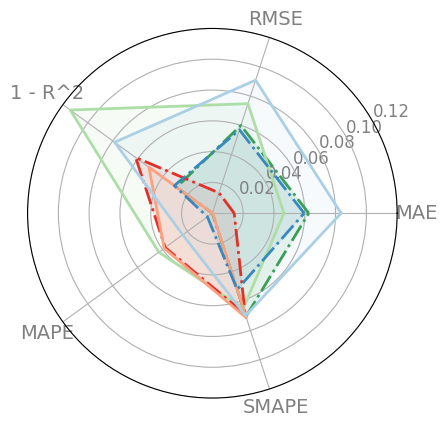

Areas for 1-step:
HSMM_EMA: 0.004702043757230868
HSMM_NoFilter: 0.010806488057554206
kNN-TSPI_EMA: 0.003317845214442222
kNN-TSPI_NoFilter: 0.0022611420037448957
Encoder-Decoder_EMA: 0.004072214064912525
Encoder-Decoder_NoFilter: 0.011459326833687401

Friedman Test Results for Index(['HSMM_EMA', 'HSMM_NoFilter', 'kNN-TSPI_EMA', 'kNN-TSPI_NoFilter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_NoFilter'],
      dtype='object', name='Model_Filter'):
  Stat: 5.914285714285711
  P-value: 0.31464885832104006

No significant difference found for:

Step Size: 1Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 2Step
HSMM_EMA 0.005435197788313884
Metric values: [6.54122318e-02 6.40233912e-02 3.76165796e-02 2.59768770e-13
 7.38937700e-02 6.54122318e-02]
HSMM_NoFilter 0.008475797880314117
Metric values: [0.04151425 0.06553691 0.10317557 0.

<ipython-input-3-18eac64eeb0e>:290: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


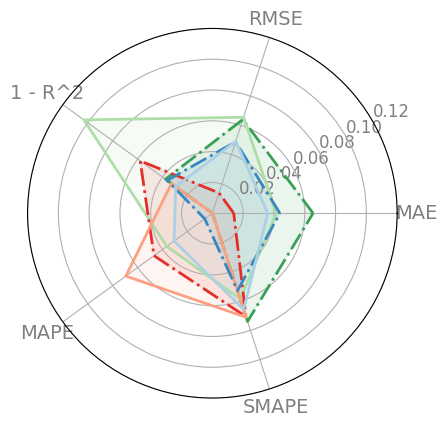

Areas for 2-step:
HSMM_EMA: 0.005435197788313884
HSMM_NoFilter: 0.008475797880314117
kNN-TSPI_EMA: 0.0038056724424941468
kNN-TSPI_NoFilter: 0.0034307982925810597
Encoder-Decoder_EMA: 0.0032191305107456512
Encoder-Decoder_NoFilter: 0.004043906724598272

Friedman Test Results for Index(['HSMM_EMA', 'HSMM_NoFilter', 'kNN-TSPI_EMA', 'kNN-TSPI_NoFilter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_NoFilter'],
      dtype='object', name='Model_Filter'):
  Stat: 4.085714285714289
  P-value: 0.5371424252506449

No significant difference found for:

Step Size: 2Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 5Step
HSMM_EMA 0.0029480679218051578
Metric values: [4.79327539e-02 4.80641430e-02 2.82379438e-02 2.00696218e-13
 5.29592941e-02 4.79327539e-02]
HSMM_NoFilter 0.004418839104270355
Metric values: [0.02960571 0.04491078 0.07603762 

<ipython-input-3-18eac64eeb0e>:290: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


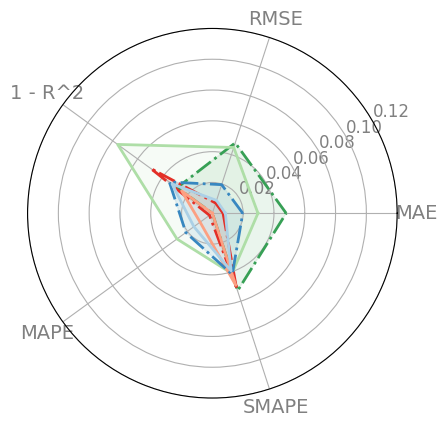

Areas for 5-step:
HSMM_EMA: 0.0029480679218051578
HSMM_NoFilter: 0.004418839104270355
kNN-TSPI_EMA: 0.00046111390339181315
kNN-TSPI_NoFilter: 0.00034580094075027223
Encoder-Decoder_EMA: 0.0016697465992811225
Encoder-Decoder_NoFilter: 0.000833692587095913

Friedman Test Results for Index(['HSMM_EMA', 'HSMM_NoFilter', 'kNN-TSPI_EMA', 'kNN-TSPI_NoFilter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_NoFilter'],
      dtype='object', name='Model_Filter'):
  Stat: 7.514285714285705
  P-value: 0.18511414529837938

No significant difference found for:

Step Size: 5Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 10Step
HSMM_EMA 0.0062190375894203296
Metric values: [6.92987856e-02 6.92103778e-02 4.34911331e-02 1.55421945e-12
 7.60754067e-02 6.92987856e-02]
HSMM_NoFilter 0.007706743496783583
Metric values: [0.04002654 0.06164699 0.0944

<ipython-input-3-18eac64eeb0e>:290: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


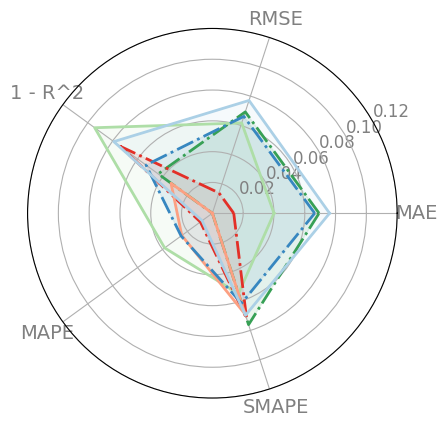

Areas for 10-step:
HSMM_EMA: 0.0062190375894203296
HSMM_NoFilter: 0.007706743496783583
kNN-TSPI_EMA: 0.0017233636318949074
kNN-TSPI_NoFilter: 0.001192647689914247
Encoder-Decoder_EMA: 0.007074174806200006
Encoder-Decoder_NoFilter: 0.008787015203321952

Friedman Test Results for Index(['HSMM_EMA', 'HSMM_NoFilter', 'kNN-TSPI_EMA', 'kNN-TSPI_NoFilter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_NoFilter'],
      dtype='object', name='Model_Filter'):
  Stat: 5.342857142857142
  P-value: 0.375484899356519

No significant difference found for:

Step Size: 10Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 15Step
HSMM_EMA 0.006439159209659451
Metric values: [7.00548792e-02 7.06472413e-02 4.54486095e-02 3.84590331e-13
 7.68121015e-02 7.00548792e-02]
HSMM_NoFilter 0.007982305811593295
Metric values: [0.03801251 0.05813554 0.10188432 

<ipython-input-3-18eac64eeb0e>:290: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


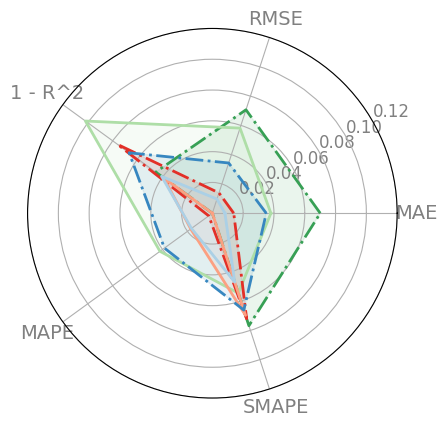

Areas for 15-step:
HSMM_EMA: 0.006439159209659451
HSMM_NoFilter: 0.007982305811593295
kNN-TSPI_EMA: 0.0012729386359538132
kNN-TSPI_NoFilter: 0.0008967020156767773
Encoder-Decoder_EMA: 0.005193050656142873
Encoder-Decoder_NoFilter: 0.0011083341028494341

Friedman Test Results for Index(['HSMM_EMA', 'HSMM_NoFilter', 'kNN-TSPI_EMA', 'kNN-TSPI_NoFilter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_NoFilter'],
      dtype='object', name='Model_Filter'):
  Stat: 9.57142857142857
  P-value: 0.08833030024086631

No significant difference found for:

Step Size: 15Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']



In [7]:
# Run


areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory)

    # Plot the star chart and get the areas
    model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    areas_dict[step_size] = model_areas
    print(f'Areas for {get_step_size_name(step_size)}:')
    for model_filter_combo, area in model_areas.items():
        print(f'{model_filter_combo}: {area}')
    print()

    # Transpose the dataframe to compare models instead of metrics
    metrics_df_transposed = metrics_df.T

    # predictions_df_transposed = predictions_df.T

    nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    #check if nemenyi_df is not None
    if nemenyi_df is not None:
        # Calculate the critical difference
        cd = calculate_critical_difference(nemenyi_df)
        
        # # Plot the critical difference diagram
        plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    else:
        print("No significant difference found for:")

        print()
        
        print('Step Size:', step_size)
        print('Models:', models)
        print('Devices:', devices)
        print("Filters:", filters)
        print('Selected Metrics:', selected_metrics)
        
        print()

In [24]:
def calculate_smape(actual, predicted):
    
        # Convert actual and predicted to numpy
        # array data type if not already
        if not all([isinstance(actual, np.ndarray), 
                    isinstance(predicted, np.ndarray)]):
            actual, predicted = np.array(actual),
            np.array(predicted)
    
        return round(
            np.mean(
                np.abs(predicted - actual) / 
                ((np.abs(predicted) + np.abs(actual))/2)
            )*100, 2
        )

def calc_metrics(preds_df,model_type,rpi,filter,csv_name):


    if os.path.exists(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}'):
        # print(f'{csv_name} already exists. Loading metrics per inst.')
        return pd.read_csv(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}')

    print(f"Processing: {model_type}, {rpi}, {filter}, {csv_name}")
    metrics_per_inst, selected_resources_obs, selected_resources_prds = [], [], []
    selected_resources = ['cpu_user_time_diff', 'cpu_system_time_diff', 'cpu_idle_time_diff', 'memory']
    
    columns = preds_df.columns
    for col in columns:
        if 'obs' in col:
            selected_resources_obs.append(col)
        elif 'preds' in col:
            selected_resources_prds.append(col)
    
    def calculate_one_minus_r2(observations, predictions):

        true_values = [float(x) for x in observations]
        predicted_values = [float(x) for x in predictions]

        return 1 - r2_score(true_values, predicted_values)

    for obs, preds, res in zip(selected_resources_obs, selected_resources_prds, selected_resources):

        # Calculate metrics
        preds_df[res+'_MAE'] = preds_df.apply(lambda row: round(mean_absolute_error([row[obs]], [row[preds]]),3), axis=1)
        metrics_per_inst.append(res+'_MAE')
        preds_df[res+'_RMSE'] = preds_df.apply(lambda row: round(mean_squared_error([row[obs]], [row[preds]], squared=False),3), axis=1)
        metrics_per_inst.append(res+'_RMSE')
        # preds_df[res+'_1-R^2'] = preds_df.apply(lambda row: round(calculate_one_minus_r2([row[obs]], [row[preds]]),3), axis=1)
        # metrics_per_inst.append(res+'_1-R^2')
        preds_df[res+'_MAPE'] = preds_df.apply(lambda row: round(mean_absolute_percentage_error([row[obs]], [row[preds]])*100,2), axis=1)
        metrics_per_inst.append(res+'_MAPE')
        preds_df[res+'_SMAPE'] = preds_df.apply(lambda row: round(calculate_smape(np.array(row[obs]), np.array(row[preds])),2), axis=1)
        metrics_per_inst.append(res+'_SMAPE')
        
    result_df = preds_df[metrics_per_inst]

    os.makedirs(os.path.join('Results', model_type, rpi, filter,'metrics_per_inst'), exist_ok=True)

    print('Saving metrics to {}'.format(csv_name))
    # Save metrics to a CSV file
    result_df.to_csv(r'Results/{}/{}/{}/metrics_per_inst/{}'.format(model_type,rpi,filter,csv_name), index=False)

    return result_df


def get_step_size_name(step_size):
    step_size_dict = {'1Step': '1-step', '2Step': '2-step', '5Step': '5-step', '10Step': '10-step', '15Step': '15-step'}
    return step_size_dict.get(step_size)

def get_filter_name(filter_name):
    filter_dict = {'':'No Filter', '_sg_5_2' : 'SavGol', '_sma_2': 'SMA', '_ema_1':'EMA' }
    return filter_dict.get(filter_name)

def get_model_name(model_name):
    model_dict = {'kNN-TSPI':'kNN-TSPI', 'HSMM' : 'RUMP', 'Encoder-Decoder': 'HBLED' }
    return model_dict.get(model_name)

def shoelace_formula(x, y):
    """
    The Shoelace formula, also known as Gauss's area formula 
    or the surveyor's formula, is a method for calculating 
    the area of a simple polygon with known vertex coordinates. 
    The formula is named "Shoelace" because of the pattern the 
    multiplications create, which resembles lacing up a shoe.
    """
    return 0.5 * abs(sum(x[i] * y[i + 1] - x[i + 1] * y[i] for i in range(-1, len(x) - 1)))




def perform_friedman_nemenyi_wilcoxon_tests(data, prds_data):
    """
    Perform Friedman test, Wilcoxon test, and Nemenyi test to compute critical difference diagram.
    """
    # Perform Friedman test

    # Check if there are at least 3 sets of samples
    if data.shape[1] >= 3:
      friedman_stat, friedman_p = friedmanchisquare(*[data[col] for col in data.columns])
      print(f"Friedman Test Results for {data.columns.get_level_values('Model_Filter')}:")
      print(f"  Stat: {friedman_stat}")
      print(f"  P-value: {friedman_p}\n")
      wilcoxon_p = 1
    else:
      # Perform Wilcoxon test for each pair of columns
      print(f"Wilcoxon Test Results  for {data.columns.get_level_values('Model_Filter')}::")
      for i, col1 in enumerate(data.columns):
        for j, col2 in enumerate(data.columns):
          if i < j:
            wilcoxon_stat, wilcoxon_p = wilcoxon(data[col1], data[col2])
            print(f"  {col1} vs {col2}:")
            print(f"    Stat: {wilcoxon_stat}")
            print(f"    P-value: {wilcoxon_p}\n")
            friedman_p = 1

    # check if prds_data (dataframe) is not empty
    if not prds_data.empty and (friedman_p < 0.05 or wilcoxon_p < 0.05):
        # Perform Nemenyi test
        metrics = prds_data.columns.to_list()
        metrics.remove('Model_Filter')
        nemenyi_dfs = []
        for metric in metrics:

            
            # Extract the relevant column and group by the Model_Filter
            grouped_data = prds_data[[metric, 'Model_Filter']].groupby('Model_Filter')
            # Transform the grouped data into a format suitable for the Nemenyi test
            data_for_nemenyi = [group[metric].values for _, group in grouped_data]

            # Perform the Nemenyi test
            nemenyi_result = sp.posthoc_nemenyi(data_for_nemenyi)

            # print("Nemenyi Test Results:")
            # print(nemenyi_result)

            # Convert the Nemenyi result to a DataFrame with appropriate column and index names
            nemenyi_dfs.append(pd.DataFrame(nemenyi_result, columns=data.columns, index=data.columns))
        
        return pd.concat(nemenyi_dfs)
    else:
        return None

def calculate_critical_difference(nemenyi_df, alpha=0.05):
    """
    Calculate the critical difference.
    """
    k = nemenyi_df.shape[1]
    N = nemenyi_df.shape[0]

    q_alpha = t.ppf(1 - alpha / (2 * k * (k - 1)), N - 1)
    cd = q_alpha * np.sqrt(k * (k + 1) / (6 * N))
    print(f"Critical difference: {cd:.3f}")
    return cd


def plot_critical_difference(nemenyi_df, step_size, cd, filename=None):
    """
    Plot the critical difference diagram using matplotlib.
    """
    average_ranks = pd.Series(nemenyi_df.apply(lambda x: rankdata(x, method="average"), axis=1).mean())

    # Sort average_ranks and names
    average_ranks = average_ranks.sort_values()
    sorted_indices = average_ranks.index
    names = nemenyi_df.columns[sorted_indices]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.subplots_adjust(left=0.1, right=0.9)

    ax.set_xlim(-0.5, len(average_ranks) - 0.5)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_position(("axes", 0.6))
    ax.xaxis.set_ticks_position("top")
    ax.yaxis.set_visible(False)
    #increase ticks size
    ax.tick_params(axis='both', which='major', labelsize=22)

    for pos in ["bottom", "left", "right"]:
        ax.spines[pos].set_visible(False)

    # CD bar
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1 - cd], [0.9, 0.9], color="k")
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.plot([len(average_ranks) - 1 - cd, len(average_ranks) - 1 - cd], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.text(len(average_ranks) - 1 - cd / 4.0, 0.92, "CD", ha="center", va="bottom", fontsize=26)

    # Pairwise comparisons
    comparisons = []
    for i, col1 in enumerate(names):
        for j, col2 in enumerate(names):
            if i < j:
                p_value = nemenyi_df.loc[col1, col2]
                if p_value.any() < 0.05:
                    comparisons.append((i, j))

    # for i, j in comparisons:
    #     ax.plot([i, j], [0.9, 0.9], color="k", lw=1)
    #     ax.plot([i, i], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)
    #     ax.plot([j, j], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)

    # Annotations
    for (i, j), name in zip(comparisons, names):
        print(name)
        ax.plot([i, i], [0.62, 0.55], color="k", lw=3)
        wrapped_name = textwrap.fill(str(name[1].split("_")[0])+'_'+str(("_".join(name[1].split("_")[1:]))), width=30)  # Wrap the name if it's too long
        level = (i % 3) * 0.19  # Alternate between 0, 1, 2, and 3 for separate levels
    
        if i % 3 == 0:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="bottom", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.68], color="k", linestyle="--", lw=1)
        else:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="top", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.55], color="k", linestyle="--", lw=1)
        


      
    # ax.set_title(f"Critical Difference Diagram for {step_size}", fontsize=12)
    # plt.tight_layout()

    if filename:
        fig_directory = os.path.join('Figures', 'Experiments', f"{filename}_CD.png")
        plt.savefig(fig_directory, bbox_inches='tight')

    
    plt.show()
    plt.close()



def create_filter_star_chart(data, title, y_lim, filename=None):
    
    scale = 1

    num_vars = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles, data.columns, color='grey', size=14)
    ax.set_rlabel_position(30)
    plt.yticks(color="grey", size=12)
    plt.ylim(0, y_lim * scale)

    groups = defaultdict(list)
    for index, data_values in data.iterrows():
        model_name, model_filter = index
        filter_type = model_filter
        groups[model_name].append((filter_type, data_values))

    areas = {}
    areas_list = []

    # Define color palettes for each group
    group_colors = {
        'Encoder-Decoder': sns.color_palette("Blues_r", len(groups['Encoder-Decoder'])), # Spectral_r, “Greens_r”
        'kNN-TSPI': sns.color_palette("Reds_r", len(groups['kNN-TSPI'])), # “Reds_r”, "Purples_r"
        'HSMM': sns.color_palette("Greens_r", len(groups['HSMM'])) # “Greys_r”
    }
    # all colors: https://seaborn.pydata.org/tutorial/color_palettes.html

    # Define linestylte palettes for each model
    model_linestyles = {
        'Encoder-Decoder': ['-.', '-', '--', ':'],
        'kNN-TSPI': ['-.', '-', '--', ':'],
        'HSMM': ['-.', '-', '--', ':']
    }


    for model_name, group_data in groups.items():
        group_color = group_colors.get(model_name)

        for filter_idx, (filter_type, data_values) in enumerate(group_data):
            data_values = np.concatenate((data_values, [data_values[0]]))
            angles_cycle = angles + angles[:1]

            x = data_values * np.cos(angles_cycle)
            y = data_values * np.sin(angles_cycle)

            area = shoelace_formula(x, y)
            model_filt_combo = filter_type
            print(model_filt_combo, area)
            areas_list.append(area)
            areas[model_filt_combo] = area

            # Find the index of the current filter type in the group data
            filter_idx = [x[0] for x in group_data].index(filter_type)

            # Compute the normalized area value
            area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


            # Compute the color for the current polygon based on the group color and the normalized area value
            color = group_color[filter_idx] if group_color else sns.color_palette("dark", 1)[0]
            shade = color if area_value == 0 else sns.blend_palette([color, 'white'], as_cmap=True)(area_value)

            print('Metric values:', data_values)

            # Scale data_values
            data_values = data_values * scale

            ax.plot(angles_cycle, data_values, linewidth=2, linestyle= model_linestyles.get(model_name)[filter_idx] , label=f"{get_model_name(filter_type.split('_')[0])} - {filter_type.split('_')[1]}", color=color)
            ax.fill(angles_cycle, data_values, alpha=0.1, color=color)

            

    normalized_areas = (areas_list - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))
    

    print(title)
    plt.legend(loc='lower right', bbox_to_anchor=(1.7, 0.25), fontsize=12)
    plt.gca().set_facecolor('white')
    

    if filename:
        fig_directory = os.path.join('Figures','Experiments',f"{filename}_Star.png")
        plt.savefig(fig_directory, bbox_inches='tight')
    
    plt.show()
    plt.close()

    return areas



def preprocess_data(data, normalization_method="min_max"):
    
    def min_max_scaling(column):
        return (column - global_min) / (global_max - global_min)

    def z_score_standardization(column):
        return (column - column.mean()) / column.std()

    def log_transformation(column):
        return np.log(column + 1 - column.min())

    def percentile_based_scaling(column):
        return (column - column.median()) / (column.quantile(0.75) - column.quantile(0.25))

    def unit_vector_scaling(column):
        norm = np.sqrt(np.sum(column**2))
        return column / norm

    normalization_methods = {
        "min_max": min_max_scaling,
        "z_score": z_score_standardization,
        "log": log_transformation,
        "percentile": percentile_based_scaling,
        "unit_vector": unit_vector_scaling,
    }

    if normalization_method not in normalization_methods:
        raise ValueError(f"Invalid normalization method: {normalization_method}")

    # Exclude the 'Filter_Type' column during normalization
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_normalized = data.copy()

    # Calculate the global min and max for all model/filter combinations
    global_min = data[numeric_columns].min().min()
    global_max = data[numeric_columns].max().max()

    # Apply the selected normalization method
    normalization_func = normalization_methods[normalization_method]
    data_normalized[numeric_columns] = data[numeric_columns].apply(normalization_func)

    return data_normalized



def remove_outliers(data, csv_file, directory):
    # Identify and remove outliers using IQR method
    Q1 = data.quantile(0.05, numeric_only=True)
    Q3 = data.quantile(0.95, numeric_only=True)
    IQR = Q3 - Q1
    
    # Align the DataFrame and Series before making the comparison
    lower_bound, _ = data.align(Q1 - 1.5 * IQR, axis=1, copy=False)
    upper_bound, _ = data.align(Q3 + 1.5 * IQR, axis=1, copy=False)
    
    # Find outliers
    outliers_mask = (data.lt(lower_bound) | data.gt(upper_bound)).any(axis=1)
    
    # Track the number of outliers
    outlier_count = outliers_mask.sum()
    
    # Display information about outliers
    if outlier_count > 0:
        print(f"File: {csv_file} - Total outliers: {outlier_count} - Directory: {directory}")
        print("Outliers count per metric:")
        print((data[outliers_mask]).count())
        print("Sample outlier values:")
        print(data[outliers_mask].head(5))  # Adjust the number of samples as needed
    
    # Remove outliers
    data = data[~outliers_mask]

    return data

def get_metric_per_inst(step_size, models, devices, filters, root_directory):
    preds_data = []
    for model in models:
        predictions_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                # try:
                
                    device_directory_predictions = os.path.join(root_directory, model, device, filter_name, 'metrics_per_inst')
                    
                    # Get all the csv files in the directory
                    csv_files = [f for f in os.listdir(device_directory_predictions) if f.endswith(step_size + '.csv')]

                    for csv_file in csv_files:
                        
                        predictions_file_path = os.path.join(device_directory_predictions, csv_file)

                        predictions_data = pd.read_csv(predictions_file_path)
                        predictions_data = predictions_data.applymap(parse_float)

                        predictions_data = calc_metrics(predictions_data, model, device, filter_name, csv_file)
                        
                        predictions_data = remove_outliers(predictions_data, csv_file, device_directory_predictions)

                        cols = predictions_data.columns

                        predictions_data['Model_Filter'] = model+'_'+get_filter_name(filter_name)
                        
                        reshaped_df = pd.DataFrame()
                        # Iterate over each metric and model-filter combination
                        for metric, model_filter in product(cols, predictions_data['Model_Filter'].unique()):
                            # Create a new column in the reshaped DataFrame for each model-filter combination
                            col_name = f'{metric}_{model_filter}'
                            metric_df = predictions_data.loc[predictions_data['Model_Filter'] == model_filter, metric]
                            reshaped_df[col_name] = metric_df.values
                        
                        predictions_data_frames.append(predictions_data)

               
                # except:
                #     print(f"Missing: {model}, {device}, {filter_name}, {step_size}")
 
        # Organizing Predictions Data
        combined_predictions_data = pd.concat(predictions_data_frames)
        
        preds_data.append(combined_predictions_data)


    return pd.concat(preds_data)

def get_metrics(step_size, models, devices, filters, root_directory):
    model_data = []
    for model in models:
        metrics_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                try:
                
                    device_directory_metrics = os.path.join(root_directory, model, device, filter_name, 'metrics')

                    # Get all the csv files in the directory
                    csv_files = [f for f in os.listdir(device_directory_metrics) if f.endswith(step_size + '.csv')]

                    for csv_file in csv_files:
                        
                        metrics_file_path = os.path.join(device_directory_metrics, csv_file)
                        metrics_data = pd.read_csv(metrics_file_path)

                        # metrics_data = remove_outliers(metrics_data, csv_file, device_directory_metrics)

                        metrics_data['Filter_Type'] = get_filter_name(filter_name)  # Add a new column with the filter_name
                        metrics_data_frames.append(metrics_data)
                        
                except:
                    print(f"Missing: {model}, {device}, {filter_name}, {step_size}")
        
        # Organizing Metrics Data
        combined_metrics_data = pd.concat(metrics_data_frames)
        selected_metrics_data = combined_metrics_data[selected_metrics]

        # Create a copy of the selected_data slice
        selected_metrics_data = selected_metrics_data.copy()

        # Transform the R2 score to a value that needs to be minimized
        selected_metrics_data.loc[:, 'Score'] = 1 - selected_metrics_data['Score']
        selected_metrics_data.rename(columns={"Score": "1 - R^2"}, inplace=True)

        selected_metrics_data['Filter_Type'] = combined_metrics_data['Filter_Type']  # Copy the 'Filter_Type' column before preprocessing
        preprocessed_metrics_data = preprocess_data(selected_metrics_data,normalization_method="unit_vector") # "unit_vector", "log", "min_max","z_score","percentile"
         
        # unit-vector Using unit vector normalization (also known as L2 normalization) 
        # scales each data point so that it has a magnitude of 1. 
        # This means that the comparisons between data points
        #  will be based on the direction (the proportions of the different metrics)
        #  rather than the magnitude (the absolute values of the metrics).

        # print(model)  # Print the model name
        # print("Preprocessed data by model/filter combination:")
        # print(preprocessed_metrics_data.groupby('Filter_Type').describe())  # Print the description of the preprocessed data by filter type

        mean_values = preprocessed_metrics_data.groupby('Filter_Type').mean().reset_index()  # Group by Filter_Type and calculate mean
        mean_values['Model'] = model  # Add a new column with the model name
        mean_values['Model_Filter'] = model + '_' + mean_values['Filter_Type']  # Create a combined column for model and filter
        mean_values = mean_values.set_index(['Model', 'Model_Filter'])  # Set the new 'Model_Filter' column as the index along with 'Model'
        mean_values = mean_values.drop(columns=['Filter_Type'])  # Drop the original 'Filter_Type' column

        model_data.append(mean_values)


    return pd.concat(model_data)



def parse_float(value):
    try:
        if isinstance(value, str):
            # Extract the float from the string
            match = re.search(r"[-+]?\d*\.\d+|\d+", value)
            if match:
                value = float(match.group(0))
            else:
                value = np.nan
        return float(value)
    except ValueError:
        return np.nan

Step Size: 15Step
HSMM_EMA 0.006439159209659451
Metric values: [7.00548792e-02 7.06472413e-02 4.54486095e-02 3.84590331e-13
 7.68121015e-02 7.00548792e-02]
HSMM_No Filter 0.007982305811593295
Metric values: [0.03801251 0.05813554 0.10188432 0.04206134 0.05454736 0.03801251]
kNN-TSPI_EMA 0.0012729386359538132
Metric values: [0.01388889 0.01388889 0.0759195  0.00290179 0.07201925 0.01388889]
kNN-TSPI_No Filter 0.0008967020156767773
Metric values: [1.18096793e-71 8.65381112e-72 3.87956480e-02 1.73779653e-02
 6.97151331e-02 1.18096793e-71]
Encoder-Decoder_EMA 0.005193050656142873
Metric values: [0.03500096 0.03431587 0.06679486 0.0384832  0.06609452 0.03500096]
Encoder-Decoder_No Filter 0.0011083341028494341
Metric values: [0.00815391 0.00971302 0.04078692 0.01677189 0.0469917  0.00815391]
Star Chart for 15-step


<ipython-input-24-087118c99a85>:293: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


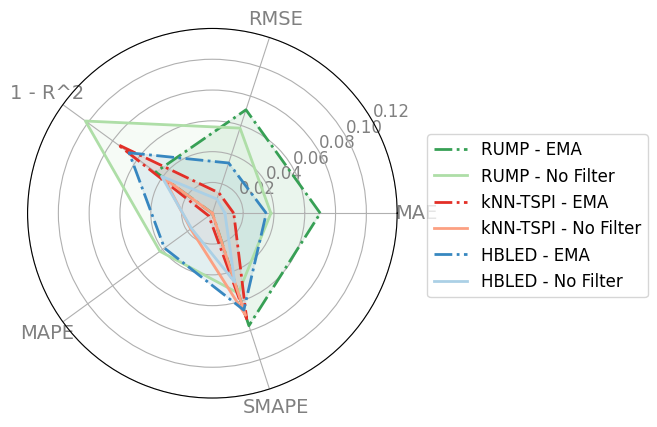

Areas for 15-step:
HSMM_EMA: 0.006439159209659451
HSMM_No Filter: 0.007982305811593295
kNN-TSPI_EMA: 0.0012729386359538132
kNN-TSPI_No Filter: 0.0008967020156767773
Encoder-Decoder_EMA: 0.005193050656142873
Encoder-Decoder_No Filter: 0.0011083341028494341

Friedman Test Results for Index(['HSMM_EMA', 'HSMM_No Filter', 'kNN-TSPI_EMA', 'kNN-TSPI_No Filter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_No Filter'],
      dtype='object', name='Model_Filter'):
  Stat: 9.57142857142857
  P-value: 0.08833030024086631

No significant difference found for:

Step Size: 15Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']



In [25]:
# Run 15 - label


areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory)

    # Plot the star chart and get the areas
    model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    areas_dict[step_size] = model_areas
    print(f'Areas for {get_step_size_name(step_size)}:')
    for model_filter_combo, area in model_areas.items():
        print(f'{model_filter_combo}: {area}')
    print()

    # Transpose the dataframe to compare models instead of metrics
    metrics_df_transposed = metrics_df.T

    # predictions_df_transposed = predictions_df.T

    nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    #check if nemenyi_df is not None
    if nemenyi_df is not None:
        # Calculate the critical difference
        cd = calculate_critical_difference(nemenyi_df)
        
        # # Plot the critical difference diagram
        plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    else:
        print("No significant difference found for:")

        print()

        print('Step Size:', step_size)
        print('Models:', models)
        print('Devices:', devices)
        print("Filters:", filters)
        print('Selected Metrics:', selected_metrics)
        
        print()

In [29]:
def calculate_smape(actual, predicted):
    
        # Convert actual and predicted to numpy
        # array data type if not already
        if not all([isinstance(actual, np.ndarray), 
                    isinstance(predicted, np.ndarray)]):
            actual, predicted = np.array(actual),
            np.array(predicted)
    
        return round(
            np.mean(
                np.abs(predicted - actual) / 
                ((np.abs(predicted) + np.abs(actual))/2)
            )*100, 2
        )

def calc_metrics(preds_df,model_type,rpi,filter,csv_name):


    if os.path.exists(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}'):
        # print(f'{csv_name} already exists. Loading metrics per inst.')
        return pd.read_csv(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}')

    print(f"Processing: {model_type}, {rpi}, {filter}, {csv_name}")
    metrics_per_inst, selected_resources_obs, selected_resources_prds = [], [], []
    selected_resources = ['cpu_user_time_diff', 'cpu_system_time_diff', 'cpu_idle_time_diff', 'memory']
    
    columns = preds_df.columns
    for col in columns:
        if 'obs' in col:
            selected_resources_obs.append(col)
        elif 'preds' in col:
            selected_resources_prds.append(col)
    
    def calculate_one_minus_r2(observations, predictions):

        true_values = [float(x) for x in observations]
        predicted_values = [float(x) for x in predictions]

        return 1 - r2_score(true_values, predicted_values)

    for obs, preds, res in zip(selected_resources_obs, selected_resources_prds, selected_resources):

        # Calculate metrics
        preds_df[res+'_MAE'] = preds_df.apply(lambda row: round(mean_absolute_error([row[obs]], [row[preds]]),3), axis=1)
        metrics_per_inst.append(res+'_MAE')
        preds_df[res+'_RMSE'] = preds_df.apply(lambda row: round(mean_squared_error([row[obs]], [row[preds]], squared=False),3), axis=1)
        metrics_per_inst.append(res+'_RMSE')
        # preds_df[res+'_1-R^2'] = preds_df.apply(lambda row: round(calculate_one_minus_r2([row[obs]], [row[preds]]),3), axis=1)
        # metrics_per_inst.append(res+'_1-R^2')
        preds_df[res+'_MAPE'] = preds_df.apply(lambda row: round(mean_absolute_percentage_error([row[obs]], [row[preds]])*100,2), axis=1)
        metrics_per_inst.append(res+'_MAPE')
        preds_df[res+'_SMAPE'] = preds_df.apply(lambda row: round(calculate_smape(np.array(row[obs]), np.array(row[preds])),2), axis=1)
        metrics_per_inst.append(res+'_SMAPE')
        
    result_df = preds_df[metrics_per_inst]

    os.makedirs(os.path.join('Results', model_type, rpi, filter,'metrics_per_inst'), exist_ok=True)

    print('Saving metrics to {}'.format(csv_name))
    # Save metrics to a CSV file
    result_df.to_csv(r'Results/{}/{}/{}/metrics_per_inst/{}'.format(model_type,rpi,filter,csv_name), index=False)

    return result_df


def get_step_size_name(step_size):
    step_size_dict = {'1Step': '1-step', '2Step': '2-step', '5Step': '5-step', '10Step': '10-step', '15Step': '15-step'}
    return step_size_dict.get(step_size)

def get_filter_name(filter_name):
    filter_dict = {'':'No Filter', '_sg_5_2' : 'SavGol', '_sma_2': 'SMA', '_ema_1':'EMA' }
    return filter_dict.get(filter_name)

def get_model_name(model_name):
    model_dict = {'kNN-TSPI':'kNN-TSPI', 'HSMM' : 'RUMP', 'Encoder-Decoder': 'HBLED' }
    return model_dict.get(model_name)

def shoelace_formula(x, y):
    """
    The Shoelace formula, also known as Gauss's area formula 
    or the surveyor's formula, is a method for calculating 
    the area of a simple polygon with known vertex coordinates. 
    The formula is named "Shoelace" because of the pattern the 
    multiplications create, which resembles lacing up a shoe.
    """
    return 0.5 * abs(sum(x[i] * y[i + 1] - x[i + 1] * y[i] for i in range(-1, len(x) - 1)))




def perform_friedman_nemenyi_wilcoxon_tests(data, prds_data):
    """
    Perform Friedman test, Wilcoxon test, and Nemenyi test to compute critical difference diagram.
    """
    # Perform Friedman test

    # Check if there are at least 3 sets of samples
    if data.shape[1] >= 3:
      friedman_stat, friedman_p = friedmanchisquare(*[data[col] for col in data.columns])
      print(f"Friedman Test Results for {data.columns.get_level_values('Model_Filter')}:")
      print(f"  Stat: {friedman_stat}")
      print(f"  P-value: {friedman_p}\n")
      wilcoxon_p = 1
    else:
      # Perform Wilcoxon test for each pair of columns
      print(f"Wilcoxon Test Results  for {data.columns.get_level_values('Model_Filter')}::")
      for i, col1 in enumerate(data.columns):
        for j, col2 in enumerate(data.columns):
          if i < j:
            wilcoxon_stat, wilcoxon_p = wilcoxon(data[col1], data[col2])
            print(f"  {col1} vs {col2}:")
            print(f"    Stat: {wilcoxon_stat}")
            print(f"    P-value: {wilcoxon_p}\n")
            friedman_p = 1

    # check if prds_data (dataframe) is not empty
    if not prds_data.empty and (friedman_p < 0.05 or wilcoxon_p < 0.05):
        # Perform Nemenyi test
        metrics = prds_data.columns.to_list()
        metrics.remove('Model_Filter')
        nemenyi_dfs = []
        for metric in metrics:

            
            # Extract the relevant column and group by the Model_Filter
            grouped_data = prds_data[[metric, 'Model_Filter']].groupby('Model_Filter')
            # Transform the grouped data into a format suitable for the Nemenyi test
            data_for_nemenyi = [group[metric].values for _, group in grouped_data]

            # Perform the Nemenyi test
            nemenyi_result = sp.posthoc_nemenyi(data_for_nemenyi)

            # print("Nemenyi Test Results:")
            # print(nemenyi_result)

            # Convert the Nemenyi result to a DataFrame with appropriate column and index names
            nemenyi_dfs.append(pd.DataFrame(nemenyi_result, columns=data.columns, index=data.columns))
        
        return pd.concat(nemenyi_dfs)
    else:
        return None

def calculate_critical_difference(nemenyi_df, alpha=0.05):
    """
    Calculate the critical difference.
    """
    k = nemenyi_df.shape[1]
    N = nemenyi_df.shape[0]

    q_alpha = t.ppf(1 - alpha / (2 * k * (k - 1)), N - 1)
    cd = q_alpha * np.sqrt(k * (k + 1) / (6 * N))
    print(f"Critical difference: {cd:.3f}")
    return cd


def plot_critical_difference(nemenyi_df, step_size, cd, filename=None):
    """
    Plot the critical difference diagram using matplotlib.
    """
    average_ranks = pd.Series(nemenyi_df.apply(lambda x: rankdata(x, method="average"), axis=1).mean())

    # Sort average_ranks and names
    average_ranks = average_ranks.sort_values()
    sorted_indices = average_ranks.index
    names = nemenyi_df.columns[sorted_indices]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.subplots_adjust(left=0.1, right=0.9)

    ax.set_xlim(-0.5, len(average_ranks) - 0.5)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_position(("axes", 0.6))
    ax.xaxis.set_ticks_position("top")
    ax.yaxis.set_visible(False)
    #increase ticks size
    ax.tick_params(axis='both', which='major', labelsize=22)

    for pos in ["bottom", "left", "right"]:
        ax.spines[pos].set_visible(False)

    # CD bar
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1 - cd], [0.9, 0.9], color="k")
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.plot([len(average_ranks) - 1 - cd, len(average_ranks) - 1 - cd], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.text(len(average_ranks) - 1 - cd / 4.0, 0.92, "CD", ha="center", va="bottom", fontsize=26)

    # Pairwise comparisons
    comparisons = []
    for i, col1 in enumerate(names):
        for j, col2 in enumerate(names):
            if i < j:
                p_value = nemenyi_df.loc[col1, col2]
                if p_value.any() < 0.05:
                    comparisons.append((i, j))

    # for i, j in comparisons:
    #     ax.plot([i, j], [0.9, 0.9], color="k", lw=1)
    #     ax.plot([i, i], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)
    #     ax.plot([j, j], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)

    # Annotations
    for (i, j), name in zip(comparisons, names):
        print(name)
        ax.plot([i, i], [0.62, 0.55], color="k", lw=3)
        wrapped_name = textwrap.fill(str(name[1].split("_")[0])+'_'+str(("_".join(name[1].split("_")[1:]))), width=30)  # Wrap the name if it's too long
        level = (i % 3) * 0.19  # Alternate between 0, 1, 2, and 3 for separate levels
    
        if i % 3 == 0:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="bottom", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.68], color="k", linestyle="--", lw=1)
        else:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="top", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.55], color="k", linestyle="--", lw=1)
        


      
    # ax.set_title(f"Critical Difference Diagram for {step_size}", fontsize=12)
    # plt.tight_layout()

    if filename:
        fig_directory = os.path.join('Figures', 'Experiments', f"{filename}_CD.png")
        plt.savefig(fig_directory, bbox_inches='tight')

    
    plt.show()
    plt.close()



def create_filter_star_chart(data, title, y_lim, filename=None):
    
    scale = 1

    num_vars = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles, data.columns, color='grey', size=14)
    ax.set_rlabel_position(30)
    plt.yticks(color="grey", size=12)
    plt.ylim(0, y_lim * scale)

    groups = defaultdict(list)
    for index, data_values in data.iterrows():
        model_name, model_filter = index
        filter_type = model_filter
        groups[model_name].append((filter_type, data_values))

    areas = {}
    areas_list = []

    # Define color palettes for each group
    group_colors = {
        'Encoder-Decoder': sns.color_palette("Blues_r", len(groups['Encoder-Decoder'])), # Spectral_r, “Greens_r”
        'kNN-TSPI': sns.color_palette("Reds_r", len(groups['kNN-TSPI'])), # “Reds_r”, "Purples_r"
        'HSMM': sns.color_palette("Greens_r", len(groups['HSMM'])) # “Greys_r”
    }
    # all colors: https://seaborn.pydata.org/tutorial/color_palettes.html

    # Define linestylte palettes for each model
    model_linestyles = {
        'Encoder-Decoder': ['-.', '-', '--', ':'],
        'kNN-TSPI': ['-.', '-', '--', ':'],
        'HSMM': ['-.', '-', '--', ':']
    }


    for model_name, group_data in groups.items():
        group_color = group_colors.get(model_name)

        for filter_idx, (filter_type, data_values) in enumerate(group_data):
            data_values = np.concatenate((data_values, [data_values[0]]))
            angles_cycle = angles + angles[:1]

            x = data_values * np.cos(angles_cycle)
            y = data_values * np.sin(angles_cycle)

            area = shoelace_formula(x, y)
            model_filt_combo = filter_type
            print(model_filt_combo, area)
            areas_list.append(area)
            areas[model_filt_combo] = area

            # Find the index of the current filter type in the group data
            filter_idx = [x[0] for x in group_data].index(filter_type)

            # Compute the normalized area value
            area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


            # Compute the color for the current polygon based on the group color and the normalized area value
            color = group_color[filter_idx] if group_color else sns.color_palette("dark", 1)[0]
            shade = color if area_value == 0 else sns.blend_palette([color, 'white'], as_cmap=True)(area_value)

            print('Metric values:', data_values)

            # Scale data_values
            data_values = data_values * scale

            ax.plot(angles_cycle, data_values, linewidth=2, linestyle= model_linestyles.get(model_name)[filter_idx] , label=f"{get_model_name(filter_type.split('_')[0])} - {filter_type.split('_')[1]}", color=color)
            ax.fill(angles_cycle, data_values, alpha=0.1, color=color)

            

    normalized_areas = (areas_list - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))
    

    print(title)
    plt.legend(loc='lower right', bbox_to_anchor=(1.7, 0.25), fontsize=12)
    plt.gca().set_facecolor('white')
    

    if filename:
        fig_directory = os.path.join('Figures','Experiments',f"{filename}_Star.png")
        plt.savefig(fig_directory, bbox_inches='tight')
    
    plt.show()
    plt.close()

    return areas



def preprocess_data(data, normalization_method="min_max"):
    
    def min_max_scaling(column):
        return (column - global_min) / (global_max - global_min)

    def z_score_standardization(column):
        return (column - column.mean()) / column.std()

    def log_transformation(column):
        return np.log(column + 1 - column.min())

    def percentile_based_scaling(column):
        return (column - column.median()) / (column.quantile(0.75) - column.quantile(0.25))

    def unit_vector_scaling(column):
        norm = np.sqrt(np.sum(column**2))
        return column / norm

    normalization_methods = {
        "min_max": min_max_scaling,
        "z_score": z_score_standardization,
        "log": log_transformation,
        "percentile": percentile_based_scaling,
        "unit_vector": unit_vector_scaling,
    }

    if normalization_method not in normalization_methods:
        raise ValueError(f"Invalid normalization method: {normalization_method}")

    # Exclude the 'Filter_Type' column during normalization
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_normalized = data.copy()

    # Calculate the global min and max for all model/filter combinations
    global_min = data[numeric_columns].min().min()
    global_max = data[numeric_columns].max().max()

    # Apply the selected normalization method
    normalization_func = normalization_methods[normalization_method]
    data_normalized[numeric_columns] = data[numeric_columns].apply(normalization_func)

    return data_normalized



def remove_outliers(data, csv_file, directory):
    # Identify and remove outliers using IQR method
    Q1 = data.quantile(0.05, numeric_only=True)
    Q3 = data.quantile(0.95, numeric_only=True)
    IQR = Q3 - Q1
    
    # Align the DataFrame and Series before making the comparison
    lower_bound, _ = data.align(Q1 - 1.5 * IQR, axis=1, copy=False)
    upper_bound, _ = data.align(Q3 + 1.5 * IQR, axis=1, copy=False)
    
    # Find outliers
    outliers_mask = (data.lt(lower_bound) | data.gt(upper_bound)).any(axis=1)
    
    # Track the number of outliers
    outlier_count = outliers_mask.sum()
    
    # Display information about outliers
    if outlier_count > 0:
        print(f"File: {csv_file} - Total outliers: {outlier_count} - Directory: {directory}")
        print("Outliers count per metric:")
        print((data[outliers_mask]).count())
        print("Sample outlier values:")
        print(data[outliers_mask].head(5))  # Adjust the number of samples as needed
    
    # Remove outliers
    data = data[~outliers_mask]

    return data

def get_metric_per_inst(step_size, models, devices, filters, root_directory):
    preds_data = []
    for model in models:
        predictions_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                # try:
                
                    device_directory_predictions = os.path.join(root_directory, model, device, filter_name, 'metrics_per_inst')
                    
                    # Get all the csv files in the directory
                    csv_files = [f for f in os.listdir(device_directory_predictions) if f.endswith(step_size + '.csv')]

                    for csv_file in csv_files:
                        
                        predictions_file_path = os.path.join(device_directory_predictions, csv_file)

                        predictions_data = pd.read_csv(predictions_file_path)
                        predictions_data = predictions_data.applymap(parse_float)

                        predictions_data = calc_metrics(predictions_data, model, device, filter_name, csv_file)
                        
                        predictions_data = remove_outliers(predictions_data, csv_file, device_directory_predictions)

                        cols = predictions_data.columns

                        predictions_data['Model_Filter'] = model+'_'+get_filter_name(filter_name)
                        
                        reshaped_df = pd.DataFrame()
                        # Iterate over each metric and model-filter combination
                        for metric, model_filter in product(cols, predictions_data['Model_Filter'].unique()):
                            # Create a new column in the reshaped DataFrame for each model-filter combination
                            col_name = f'{metric}_{model_filter}'
                            metric_df = predictions_data.loc[predictions_data['Model_Filter'] == model_filter, metric]
                            reshaped_df[col_name] = metric_df.values
                        
                        predictions_data_frames.append(predictions_data)

               
                # except:
                #     print(f"Missing: {model}, {device}, {filter_name}, {step_size}")
 
        # Organizing Predictions Data
        combined_predictions_data = pd.concat(predictions_data_frames)
        
        preds_data.append(combined_predictions_data)


    return pd.concat(preds_data)

def get_metrics(step_size, models, devices, filters, root_directory, norm = None):
    model_data = []
    for model in models:
        metrics_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                try:
                
                    device_directory_metrics = os.path.join(root_directory, model, device, filter_name, 'metrics')

                    # Get all the csv files in the directory
                    csv_files = [f for f in os.listdir(device_directory_metrics) if f.endswith(step_size + '.csv')]

                    for csv_file in csv_files:
                        
                        metrics_file_path = os.path.join(device_directory_metrics, csv_file)
                        metrics_data = pd.read_csv(metrics_file_path)

                        # metrics_data = remove_outliers(metrics_data, csv_file, device_directory_metrics)

                        metrics_data['Filter_Type'] = get_filter_name(filter_name)  # Add a new column with the filter_name
                        metrics_data_frames.append(metrics_data)
                        
                except:
                    print(f"Missing: {model}, {device}, {filter_name}, {step_size}")
        
        # Organizing Metrics Data
        combined_metrics_data = pd.concat(metrics_data_frames)
        selected_metrics_data = combined_metrics_data[selected_metrics]

        # Create a copy of the selected_data slice
        selected_metrics_data = selected_metrics_data.copy()

        # Transform the R2 score to a value that needs to be minimized
        selected_metrics_data.loc[:, 'Score'] = 1 - selected_metrics_data['Score']
        selected_metrics_data.rename(columns={"Score": "1 - R^2"}, inplace=True)

        selected_metrics_data['Filter_Type'] = combined_metrics_data['Filter_Type']  # Copy the 'Filter_Type' column before preprocessing
        
        # Preprocess the data
        if norm is not None:
            preprocessed_metrics_data = preprocess_data(selected_metrics_data,normalization_method=norm) # "unit_vector", "log", "min_max","z_score","percentile"
        else:
            preprocessed_metrics_data = selected_metrics_data

        # unit-vector Using unit vector normalization (also known as L2 normalization) 
        # scales each data point so that it has a magnitude of 1. 
        # This means that the comparisons between data points
        #  will be based on the direction (the proportions of the different metrics)
        #  rather than the magnitude (the absolute values of the metrics).

        # print(model)  # Print the model name
        # print("Preprocessed data by model/filter combination:")
        # print(preprocessed_metrics_data.groupby('Filter_Type').describe())  # Print the description of the preprocessed data by filter type

        mean_values = preprocessed_metrics_data.groupby('Filter_Type').mean().reset_index()  # Group by Filter_Type and calculate mean
        mean_values['Model'] = model  # Add a new column with the model name
        mean_values['Model_Filter'] = model + '_' + mean_values['Filter_Type']  # Create a combined column for model and filter
        mean_values = mean_values.set_index(['Model', 'Model_Filter'])  # Set the new 'Model_Filter' column as the index along with 'Model'
        mean_values = mean_values.drop(columns=['Filter_Type'])  # Drop the original 'Filter_Type' column

        model_data.append(mean_values)


    return pd.concat(model_data)



def parse_float(value):
    try:
        if isinstance(value, str):
            # Extract the float from the string
            match = re.search(r"[-+]?\d*\.\d+|\d+", value)
            if match:
                value = float(match.group(0))
            else:
                value = np.nan
        return float(value)
    except ValueError:
        return np.nan

In [30]:
models = ['HSMM', 'kNN-TSPI', 'Encoder-Decoder'] #'HSMM', 'kNN-TSPI', 'Encoder-Decoder'
devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
step_sizes = ['1Step', '2Step', '5Step', '10Step','15Step'] 
filters = ['', '_ema_1']# '','_sg_5_2','_ema_1','_sma_2' ]
# fig_name = "All_models_"+ step_size
ylimit = 0.12

# models = ['kNN-TSPI', 'Encoder-Decoder'] #, 'HSMM' 
# devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
# step_sizes = [ '1Step']#, '2Step', '5Step', '10Step', '15Step'] 
# filters = ['_ema_1','','_sg_5_2'] #,'_sma_2'
# fig_name = None # step_size
# ylimit = 0.6

In [33]:
normalizer = None # "unit_vector"
root_directory = 'Results'
selected_metrics = ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 1Step
Friedman Test Results for Index(['HSMM_EMA', 'HSMM_No Filter', 'kNN-TSPI_EMA', 'kNN-TSPI_No Filter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_No Filter'],
      dtype='object', name='Model_Filter'):
  Stat: 13.799999999999997
  P-value: 0.01693101602614834

Critical difference: 0.874
('HSMM', 'HSMM_EMA')
('HSMM', 'HSMM_No Filter')
('kNN-TSPI', 'kNN-TSPI_EMA')
('kNN-TSPI', 'kNN-TSPI_No Filter')
('Encoder-Decoder', 'Encoder-Decoder_EMA')
('Encoder-Decoder', 'Encoder-Decoder_No Filter')


<ipython-input-29-0d983e982069>:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_value = nemenyi_df.loc[col1, col2]


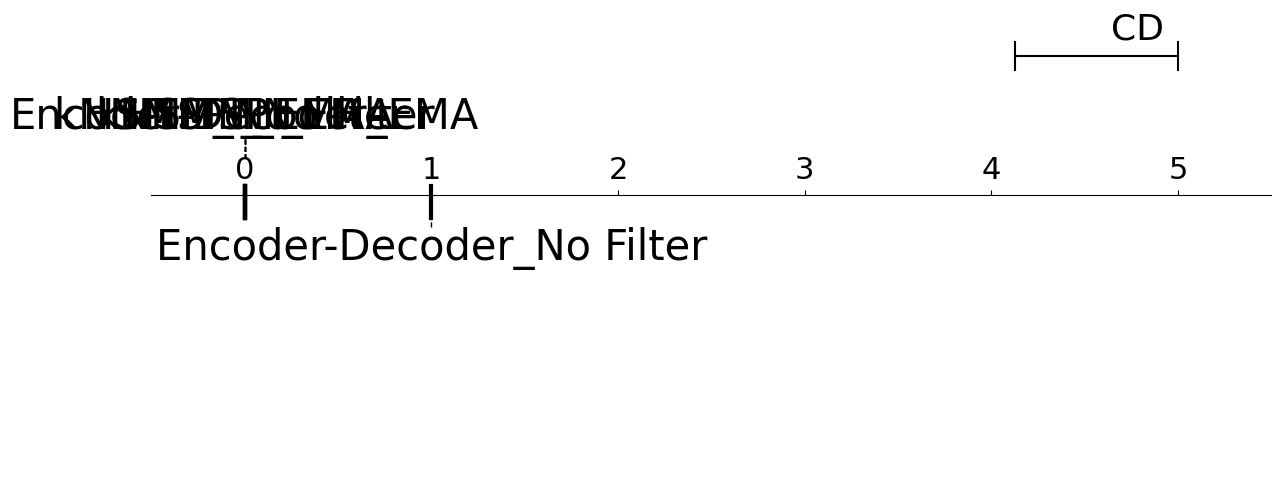

Step Size: 2Step
Friedman Test Results for Index(['HSMM_EMA', 'HSMM_No Filter', 'kNN-TSPI_EMA', 'kNN-TSPI_No Filter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_No Filter'],
      dtype='object', name='Model_Filter'):
  Stat: 10.828571428571422
  P-value: 0.05488686562562342

No significant difference found for:

Step Size: 2Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 5Step
Friedman Test Results for Index(['HSMM_EMA', 'HSMM_No Filter', 'kNN-TSPI_EMA', 'kNN-TSPI_No Filter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_No Filter'],
      dtype='object', name='Model_Filter'):
  Stat: 4.200000000000003
  P-value: 0.5209949534314045

No significant difference found for:

Step Size: 5Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selec

<ipython-input-29-0d983e982069>:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_value = nemenyi_df.loc[col1, col2]


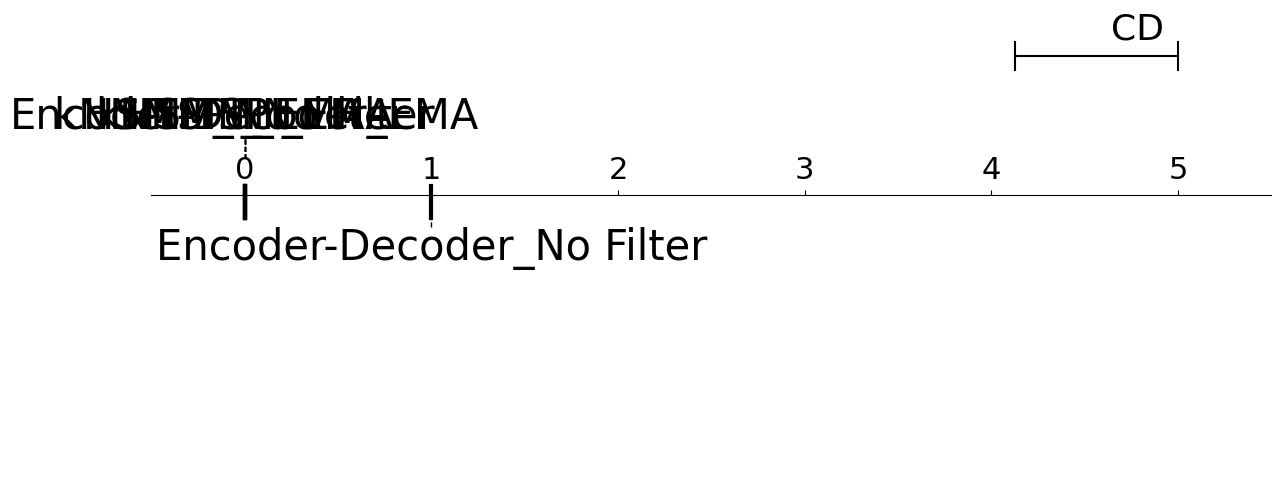

Step Size: 15Step
Friedman Test Results for Index(['HSMM_EMA', 'HSMM_No Filter', 'kNN-TSPI_EMA', 'kNN-TSPI_No Filter',
       'Encoder-Decoder_EMA', 'Encoder-Decoder_No Filter'],
      dtype='object', name='Model_Filter'):
  Stat: 5.342857142857142
  P-value: 0.375484899356519

No significant difference found for:

Step Size: 15Step
Models: ['HSMM', 'kNN-TSPI', 'Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']



In [34]:
# Run - Not normalized


areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = None # "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory, normalizer)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory)

    # # Plot the star chart and get the areas
    # model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    # areas_dict[step_size] = model_areas
    # print(f'Areas for {get_step_size_name(step_size)}:')
    # for model_filter_combo, area in model_areas.items():
    #     print(f'{model_filter_combo}: {area}')
    # print()

    # Transpose the dataframe to compare models instead of metrics
    metrics_df_transposed = metrics_df.T

    # predictions_df_transposed = predictions_df.T

    nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    #check if nemenyi_df is not None
    if nemenyi_df is not None:
        # Calculate the critical difference
        cd = calculate_critical_difference(nemenyi_df)
        
        # # Plot the critical difference diagram
        plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    else:
        print("No significant difference found for:")

        print()

        print('Step Size:', step_size)
        print('Models:', models)
        print('Devices:', devices)
        print("Filters:", filters)
        print('Selected Metrics:', selected_metrics)
        
        print()

In [35]:
models = ['HSMM']#, 'kNN-TSPI', 'Encoder-Decoder'] #'HSMM', 'kNN-TSPI', 'Encoder-Decoder'
devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
step_sizes = ['1Step', '2Step', '5Step', '10Step','15Step'] 
filters = ['', '_ema_1']# '','_sg_5_2','_ema_1','_sma_2' ]
# fig_name = "All_models_"+ step_size
ylimit = 0.12

# models = ['kNN-TSPI', 'Encoder-Decoder'] #, 'HSMM' 
# devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
# step_sizes = [ '1Step']#, '2Step', '5Step', '10Step', '15Step'] 
# filters = ['_ema_1','','_sg_5_2'] #,'_sma_2'
# fig_name = None # step_size
# ylimit = 0.6

In [36]:
# Run - HSMM - (No Filter, EMA) - Not normalized
print('HSMM - (No Filter, EMA) - Not normalized')

areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = None # "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory, normalizer)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory)

    # # Plot the star chart and get the areas
    # model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    # areas_dict[step_size] = model_areas
    # print(f'Areas for {get_step_size_name(step_size)}:')
    # for model_filter_combo, area in model_areas.items():
    #     print(f'{model_filter_combo}: {area}')
    # print()

    # Transpose the dataframe to compare models instead of metrics
    metrics_df_transposed = metrics_df.T

    # predictions_df_transposed = predictions_df.T

    nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    #check if nemenyi_df is not None
    if nemenyi_df is not None:
        # Calculate the critical difference
        cd = calculate_critical_difference(nemenyi_df)
        
        # # Plot the critical difference diagram
        plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    else:
        print("No significant difference found for:")

        print()

        print('Step Size:', step_size)
        print('Models:', models)
        print('Devices:', devices)
        print("Filters:", filters)
        print('Selected Metrics:', selected_metrics)
        
        print()

HSMM - (No Filter, EMA) - Not normalized
Step Size: 1Step
Wilcoxon Test Results  for Index(['HSMM_EMA', 'HSMM_No Filter'], dtype='object', name='Model_Filter')::
  ('HSMM', 'HSMM_EMA') vs ('HSMM', 'HSMM_No Filter'):
    Stat: 6.0
    P-value: 0.8125

No significant difference found for:

Step Size: 1Step
Models: ['HSMM']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 2Step
Wilcoxon Test Results  for Index(['HSMM_EMA', 'HSMM_No Filter'], dtype='object', name='Model_Filter')::
  ('HSMM', 'HSMM_EMA') vs ('HSMM', 'HSMM_No Filter'):
    Stat: 7.0
    P-value: 1.0

No significant difference found for:

Step Size: 2Step
Models: ['HSMM']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 5Step
Wilcoxon Test Results  for Index(['HSMM_EMA', 'HSMM_No Filter'], dtype='object', name='Mode

In [37]:
models = ['kNN-TSPI']#, 'kNN-TSPI', 'Encoder-Decoder'] #'HSMM', 'kNN-TSPI', 'Encoder-Decoder'
devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
step_sizes = ['1Step', '2Step', '5Step', '10Step','15Step'] 
filters = ['', '_ema_1']# '','_sg_5_2','_ema_1','_sma_2' ]
# fig_name = "All_models_"+ step_size
ylimit = 0.12

# models = ['kNN-TSPI', 'Encoder-Decoder'] #, 'HSMM' 
# devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
# step_sizes = [ '1Step']#, '2Step', '5Step', '10Step', '15Step'] 
# filters = ['_ema_1','','_sg_5_2'] #,'_sma_2'
# fig_name = None # step_size
# ylimit = 0.6

In [38]:
# Run - kNN-TSPI - (No Filter, EMA) - Not normalized
print('kNN-TSPI - (No Filter, EMA) - Not normalized')

areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = None # "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory, normalizer)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory)

    # # Plot the star chart and get the areas
    # model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    # areas_dict[step_size] = model_areas
    # print(f'Areas for {get_step_size_name(step_size)}:')
    # for model_filter_combo, area in model_areas.items():
    #     print(f'{model_filter_combo}: {area}')
    # print()

    # Transpose the dataframe to compare models instead of metrics
    metrics_df_transposed = metrics_df.T

    # predictions_df_transposed = predictions_df.T

    nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    #check if nemenyi_df is not None
    if nemenyi_df is not None:
        # Calculate the critical difference
        cd = calculate_critical_difference(nemenyi_df)
        
        # # Plot the critical difference diagram
        plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    else:
        print("No significant difference found for:")

        print()

        print('Step Size:', step_size)
        print('Models:', models)
        print('Devices:', devices)
        print("Filters:", filters)
        print('Selected Metrics:', selected_metrics)
        
        print()

kNN-TSPI - (No Filter, EMA) - Not normalized
Step Size: 1Step
Wilcoxon Test Results  for Index(['kNN-TSPI_EMA', 'kNN-TSPI_No Filter'], dtype='object', name='Model_Filter')::
  ('kNN-TSPI', 'kNN-TSPI_EMA') vs ('kNN-TSPI', 'kNN-TSPI_No Filter'):
    Stat: 5.0
    P-value: 0.625

No significant difference found for:

Step Size: 1Step
Models: ['kNN-TSPI']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 2Step
Wilcoxon Test Results  for Index(['kNN-TSPI_EMA', 'kNN-TSPI_No Filter'], dtype='object', name='Model_Filter')::
  ('kNN-TSPI', 'kNN-TSPI_EMA') vs ('kNN-TSPI', 'kNN-TSPI_No Filter'):
    Stat: 5.0
    P-value: 0.625

No significant difference found for:

Step Size: 2Step
Models: ['kNN-TSPI']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 5Step
Wilcoxon Test Results  for Ind

In [39]:
models = ['Encoder-Decoder']#, 'kNN-TSPI', 'Encoder-Decoder'] #'HSMM', 'kNN-TSPI', 'Encoder-Decoder'
devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
step_sizes = ['1Step', '2Step', '5Step', '10Step','15Step'] 
filters = ['', '_ema_1']# '','_sg_5_2','_ema_1','_sma_2' ]
# fig_name = "All_models_"+ step_size
ylimit = 0.12

# models = ['kNN-TSPI', 'Encoder-Decoder'] #, 'HSMM' 
# devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
# step_sizes = [ '1Step']#, '2Step', '5Step', '10Step', '15Step'] 
# filters = ['_ema_1','','_sg_5_2'] #,'_sma_2'
# fig_name = None # step_size
# ylimit = 0.6

In [40]:
# Run - Encoder-Decoder - (No Filter, EMA) - Not normalized
print('Encoder-Decoder - (No Filter, EMA) - Not normalized')

areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = None # "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory, normalizer)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory)

    # # Plot the star chart and get the areas
    # model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    # areas_dict[step_size] = model_areas
    # print(f'Areas for {get_step_size_name(step_size)}:')
    # for model_filter_combo, area in model_areas.items():
    #     print(f'{model_filter_combo}: {area}')
    # print()

    # Transpose the dataframe to compare models instead of metrics
    metrics_df_transposed = metrics_df.T

    # predictions_df_transposed = predictions_df.T

    nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    #check if nemenyi_df is not None
    if nemenyi_df is not None:
        # Calculate the critical difference
        cd = calculate_critical_difference(nemenyi_df)
        
        # # Plot the critical difference diagram
        plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    else:
        print("No significant difference found for:")

        print()

        print('Step Size:', step_size)
        print('Models:', models)
        print('Devices:', devices)
        print("Filters:", filters)
        print('Selected Metrics:', selected_metrics)
        
        print()

Encoder-Decoder - (No Filter, EMA) - Not normalized
Step Size: 1Step
Wilcoxon Test Results  for Index(['Encoder-Decoder_EMA', 'Encoder-Decoder_No Filter'], dtype='object', name='Model_Filter')::
  ('Encoder-Decoder', 'Encoder-Decoder_EMA') vs ('Encoder-Decoder', 'Encoder-Decoder_No Filter'):
    Stat: 0.0
    P-value: 0.0625

No significant difference found for:

Step Size: 1Step
Models: ['Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 2Step
Wilcoxon Test Results  for Index(['Encoder-Decoder_EMA', 'Encoder-Decoder_No Filter'], dtype='object', name='Model_Filter')::
  ('Encoder-Decoder', 'Encoder-Decoder_EMA') vs ('Encoder-Decoder', 'Encoder-Decoder_No Filter'):
    Stat: 5.0
    P-value: 0.625

No significant difference found for:

Step Size: 2Step
Models: ['Encoder-Decoder']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['', '_ema_1']
Se